<a href="https://colab.research.google.com/github/sssylvia0/Uplift_Model/blob/main/Preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocess rawdata extracted from MSSQL
1. Data format
Rawdata_YYYYMM_sql.rar -> dataYYYYMM.csv.zip
  * Train data
  * Test data(For prediction)
2. Data_size:
  * data202304.csv.zip: 1029018 rows × 162 columns
  * data202306.csv.zip:
  * data202308.csv.zip:
  * data202311.csv.zip:
3. Total time


## Data import

In [3]:
#Main import
#連接goole drive
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#解壓縮
!unrar x /content/drive/MyDrive/Sinopac/Rawdata/Rawdata_202311_sql.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Sinopac/Rawdata/Rawdata_202311_sql.rar

Extracting  Rawdata_202311_sql.csv                                         0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95%

## Data process
* 空值處理
* 重複購買（總和）
* Datatype
* Correlation
* 匯出、壓縮

In [ ]:
#Dask dataframe才能處理大型資料
import dask.dataframe as dd
import pandas as pd
c = pd.read_csv('/content/T.csv')
df = dd.read_csv('/content/Rawdata_202311_sql.csv',on_bad_lines = 'skip', names=c.names,
        dtype={'BIRTH_MM': 'float64',
       '生日月份': 'float64',
        'BILL_SEND_MARK': 'object',
       'BUS_IND_CTG': 'object',
       'CAMPAIGN_ID': 'object',
       'CONTACT_ADDR_VALID': 'object',
       'CUST_ID': 'object',
       'LEAD_ID': 'object',
       'MST_ACCT_ID': 'object',
       'OWNER_IDN': 'object',
       'PHONE8_VALID': 'object',
       'REG_QUO_MARK': 'object',
       'RLT_ACCT_MARK': 'object',
       'SALARY_PROXY_NUM': 'object',
       'SAVING_BOX_MARK': 'object',
       '企金行業別': 'object',
       '對帳單寄送記號': 'object',
       '負責人ID': 'object',
        'GENDER': 'float64',
       '性別': 'float64',
       'ELOAN_JOB_TITLE': 'object',
       'USERID': 'float64',
        'CUSTID': 'object',
        'TIMESTAMP': 'object'}
)
print("原本Columns長度：", len(df.columns))
#length = 670

原本Columns長度： 670


In [ ]:
df.columns

Index(['USERID', '客戶分層', 'UNINO', '年齡', '公司戶記號', '中小企業記號', '性別', 'CIFAOCODE',
       '呆帳記號_含信用卡', '客戶年收入',
       ...
       '證券推介開戶記號', '信用卡自動扣款記號', '數位帳戶等級記號', '換匯基因標籤', 'CUST_ID', '換匯發送名單',
       'TIMESTAMP', 'CUSTID', 'TOTALNTAMOUNT', '跨售行為'],
      dtype='object', length=174)

In [ ]:
%%time
#dask dataframe to pd.dataframe(執行約4min)
df = df.drop(df.iloc[:, 207:663], axis=1)

#移除無意義的欄位
drop_vars = [
   "負責人ID", '美金存款註記','人民幣存款註記','南非幣存款註記','總放款平均利率','一般房貸利率','理財房貸利率_LINE','理財房貸利率_LN',
   '主動推介_特定金錢信託客戶投資有價證券推介同意書', '薪轉公司統編','生日月份','客戶職稱','經管人員AO','分行別','負責人ID', '資料年月',
    '最初開戶日','最初開戶日_YYYYMM','存款開戶日', '信用卡開戶日', '信貸開戶日', '信託帳戶開戶日', '信託第一筆申購日','基金第一筆申購日',
   '房貸開戶日','證券開戶日', '全行往來產品數', '最後通聯日',
   '人身保險記號','保險要保人記號', '保險被保人記號', '產險記號','產險要保人記號', '儲蓄養老險申購記號_要保人','儲蓄養老險申購記號_被保人',
   '投資型保險申購記號_要保人', '投資型保險申購記號_被保人'
]

df = df.drop(columns=drop_vars)
#不處理時間序列 #做one-hot
drop_time = ['存款最近交易日','信託最近交易日','基金最近申購日','證券最近交易日', 'TIMESTAMP']
df = df.drop(columns=drop_time)
#將dd轉為df
df = df.compute(low_memory = False)

print('df size:', df.shape)
##df size: (1069684, 174)

df size: (1069684, 174)
CPU times: user 3min 9s, sys: 23.7 s, total: 3min 32s
Wall time: 2min 45s


###空值處理

['銀行推介_證券端記號', '跨售行為', '換匯發送名單', '換匯基因標籤', '投資屬性', '客戶行業別', '外幣活存記號', '信用卡職位別', '住宅記號', '企金行業別', 'TOTALNTAMOUNT', 'CUST_ID','CUSTID']

In [ ]:
#包含空值的欄位
print(df.columns[df.isnull().sum()>0].sort_values(ascending = False))
df.isnull().sum().sort_values(ascending = False)
'''
企金行業別            1065075
跨售行為             1061157
TOTALNTAMOUNT    1061157
CUSTID           1061157
TIMESTAMP        1061157
'''

Index(['銀行推介_證券端記號', '跨售行為', '換匯發送名單', '投資屬性', '性別', '客戶行業別', '外幣活存記號',
       '信用卡職位別', '住宅記號', '企金行業別', 'USERID', 'TOTALNTAMOUNT', 'TIMESTAMP',
       'CUST_ID', 'CUSTID'],
      dtype='object')


企金行業別            1065075
跨售行為             1061157
TOTALNTAMOUNT    1061157
CUSTID           1061157
TIMESTAMP        1061157
                  ...   
撥款總額_一般房貸_36           0
當月AP總計                 0
台外幣總存款AP               0
外幣總存款AP                0
當年度信託AP                0
Length: 174, dtype: int64

In [ ]:
#空值處理
#保留性別、客戶行業別
na_col = ['銀行推介_證券端記號', '投資屬性', '外幣活存記號',
        '信用卡職位別', '住宅記號', '企金行業別', 'CUST_ID','CUSTID', 'TIMESTAMP']
df = df.drop(columns=na_col)

In [ ]:
#客戶行業別
df['客戶行業別'][df['客戶行業別'].isnull()]='其他'
#補0
#'跨售行為', '換匯發送名單', '換匯基因標籤', 'TOTALNTAMOUNT'
df = df.fillna(0)

<ipython-input-41-30709a2e5218>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['客戶行業別'][df['客戶行業別'].isnull()]='其他'


###處理重複購買問題

In [ ]:
#確認購買人數、發送人數
print('總購買人數：', len(df[df['跨售行為']>0])) #8527
print('總發送人數：', len(df[df['換匯發送名單']>0])) #43229

#1069684-3538=1066146
df[df.duplicated(subset=['UNINO'], keep='last')] #3538 rows × 165 columns

總購買人數： 8527
總發送人數： 43229


,USERID,客戶分層,UNINO,年齡,公司戶記號,中小企業記號,性別,CIFAOCODE,呆帳記號_含信用卡,客戶年收入,...,證券庫存股股數,證券庫存股檔數,證券現股庫存市值,證券推介開戶記號,信用卡自動扣款記號,數位帳戶等級記號,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為
125,6.001064e+09,潛力戶,C1791183240,27,0,-,1.0,193800,0,641.0,...,0.0,0,0.0,0,Y,0,88.5742,0.0,8000.0,1.0
160,6.000933e+09,潛力戶,A2705430620,32,0,-,2.0,121800,0,300.0,...,0.0,0,0.0,0,N,0,94.2061,1.0,1000.0,1.0
161,6.000933e+09,潛力戶,A2705430620,32,0,-,2.0,121800,0,300.0,...,0.0,0,0.0,0,N,0,94.2061,1.0,5000.0,1.0
162,6.000933e+09,潛力戶,A2705430620,32,0,-,2.0,121800,0,300.0,...,0.0,0,0.0,0,N,0,94.2061,1.0,5000.0,1.0
285,1.000232e+09,價值戶,F1706768760,37,0,-,1.0,181S28,0,1000.0,...,0.0,0,0.0,0,N,0,98.7183,0.0,41100.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10857,1.000023e+09,潛力戶,J1796201920,44,0,-,1.0,021S66,0,2171.0,...,0.0,0,0.0,0,Y,0,96.1833,1.0,3238.0,1.0
11369,6.000571e+09,價值戶,C2725561030,55,0,-,2.0,010800,0,1000.0,...,0.0,0,0.0,1,N,0,99.2899,1.0,42920.0,1.0
11370,6.000571e+09,價值戶,C2725561030,55,0,-,2.0,010800,0,1000.0,...,0.0,0,0.0,1,N,0,99.2899,1.0,32055.0,1.0
13380,5.369138e+08,價值戶,C2792519200,41,0,-,2.0,001800,0,450.0,...,0.0,0,0.0,0,Y,0,98.2732,0.0,6399.0,1.0


In [ ]:
import pandas as pd

# 使用groupby和agg将相同UNINO的TOTALNTAMOUNT加总，同时保留所有其他列
agg_funcs = {col: 'first' if col != 'TOTALNTAMOUNT' else 'sum' for col in df.columns}
df = df.groupby('UNINO').agg(agg_funcs)
df.reset_index(drop=True)
df.shape #(1066146, 165)

(1066146, 165)

In [ ]:
df[df['TOTALNTAMOUNT']>0] #4989
df[['跨售行為', 'TOTALNTAMOUNT']][df['跨售行為']>0] #4989
df[['跨售行為', 'TOTALNTAMOUNT']][df['跨售行為']>0 & (df['TOTALNTAMOUNT']>0)] #4989

,USERID,客戶分層,UNINO,年齡,公司戶記號,中小企業記號,性別,CIFAOCODE,呆帳記號_含信用卡,客戶年收入,...,證券庫存股股數,證券庫存股檔數,證券現股庫存市值,證券推介開戶記號,信用卡自動扣款記號,數位帳戶等級記號,換匯基因標籤,換匯發送名單,TOTALNTAMOUNT,跨售行為
UNINO,,,,,,,,,,,,,,,,,,,,,
A1222756890,6.001031e+09,潛力戶,A1222756890,70,0,-,1.0,027800,0,300.0,...,0.0,0,0.0,0,N,0,95.8062,0.0,328547.0,1.0
A1228132880,1.000027e+09,價值戶,A1228132880,71,0,-,1.0,002S72,0,4800.0,...,0.0,0,0.0,0,N,0,99.8211,0.0,496789.0,1.0
A1235027770,5.371160e+08,價值戶,A1235027770,68,0,-,1.0,183S66,0,9520.0,...,0.0,0,0.0,0,Y,0,99.7196,0.0,643890.0,1.0
A1239312100,2.000023e+09,潛力戶,A1239312100,69,0,-,1.0,823J16,0,1000.0,...,0.0,0,0.0,0,Y,0,99.1012,1.0,21742.0,1.0
A1270011940,5.369610e+08,潛力戶,A1270011940,70,0,-,1.0,006S66,0,600.0,...,0.0,0,0.0,0,Y,0,97.1384,0.0,16468.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z1222600580,1.000301e+09,價值戶,Z1222600580,53,0,-,1.0,169800,0,960.0,...,9.0,72000,777010.0,0,N,0,98.6196,0.0,48529.0,1.0
Z1229212000,5.369777e+08,價值戶,Z1229212000,47,0,-,1.0,034S66,0,0.0,...,0.0,0,0.0,0,Y,0,99.8871,0.0,1988814.0,1.0
Z2222202910,5.369618e+08,潛力戶,Z2222202910,56,0,-,2.0,007S66,0,0.0,...,0.0,0,0.0,0,Y,0,94.2540,0.0,10775.0,1.0


In [ ]:
df.columns
unino = df['UNINO']
drop_id = ['USERID','UNINO', 'CIFAOCODE']
df = df.drop(columns=drop_id)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1066146 entries, 19039293TA8 to ZD522294410
Columns: 162 entries, 客戶分層 to 跨售行為
dtypes: float64(115), int64(38), object(9)
memory usage: 1.3+ GB


###Datatype 處理

In [ ]:
df.columns[df.dtypes=='object']

Index(['客戶分層', '中小企業記號', '客戶行業別', '對帳單寄送記號', '電子化通路記號_電子帳單或收EDM', '信用卡VIP客戶註記',
       '外幣存款記號', '信用卡轉呆記號', '信用卡自動扣款記號'],
      dtype='object')

In [ ]:
#Datatype 處理
#Catrgorical 變數
## define data
#var_dummy = df.columns[df.dtypes=='object']
#df = pd.get_dummies(df, columns = var_dummy, drop_first = True)
#df.insert(0, 'UNINO', unino)
df = df.reset_index(drop = True)
df.shape #(1066146, 205)

(1066146, 205)

In [ ]:
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,19039293TA8,59,0,1.0,0,0.0,1,0,0,3,...,0,0,0,1,0,0,0,0,0,0
1,19042120PA8,54,0,1.0,0,0.0,1,0,0,3,...,0,0,0,0,0,1,0,0,0,0
2,19052324OK8,60,0,1.0,0,0.0,1,0,0,3,...,0,0,0,1,0,0,0,0,0,0
3,19052578MU0,60,0,1.0,0,1000.0,1,0,0,3,...,0,0,0,0,0,1,0,1,0,0
4,19079774PA8,60,0,1.0,0,0.0,1,0,0,3,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066141,Z2229999030,80,0,2.0,0,0.0,1,2,0,3,...,0,0,0,1,0,0,0,0,0,0
1066142,Z2422221010,47,0,2.0,0,1440.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
1066143,Z2422273090,57,0,2.0,0,0.0,1,2,0,1,...,0,0,0,1,0,0,0,0,0,1
1066144,Z2794749990,55,0,2.0,0,0.0,1,0,0,3,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066146 entries, 0 to 1066145
Columns: 205 entries, UNINO to 信用卡自動扣款記號_Y
dtypes: float64(115), int64(38), object(1), uint8(51)
memory usage: 1.3+ GB


###Correlation

In [10]:
cor = df.corr()
cor

<ipython-input-10-150a9db5d4b2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df.corr()


,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,網路使用記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
年齡,1.000000,NaN,0.014575,0.027804,-0.002214,NaN,-0.160122,-0.333687,0.252089,0.061718,...,-0.012298,0.027456,-0.021964,0.291579,0.057653,-0.299607,0.040787,-0.047740,0.029101,0.165889
公司戶記號,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
性別,0.014575,NaN,1.000000,-0.021416,-0.001725,NaN,0.002971,-0.008754,-0.013189,-0.002931,...,0.054292,0.002775,-0.050174,0.000799,-0.002379,-0.000362,0.008163,0.020478,-0.017193,-0.003476
呆帳記號_含信用卡,0.027804,NaN,-0.021416,1.000000,-0.000043,NaN,0.009463,-0.014440,-0.011113,-0.016378,...,-0.005612,-0.002083,-0.003014,0.018999,0.011366,-0.020907,-0.008160,-0.017157,0.929206,-0.015777
客戶年收入,-0.002214,NaN,-0.001725,-0.000043,1.000000,NaN,0.005656,-0.002851,-0.008017,-0.001532,...,0.001674,0.000629,-0.000927,-0.009057,-0.001352,0.009226,0.000897,0.009380,0.000092,-0.000835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
對帳單寄送記號_2,-0.299607,NaN,-0.000362,-0.020907,0.009226,NaN,0.209696,0.056684,-0.402243,0.036085,...,0.043339,0.004515,0.048450,-0.983255,-0.137527,1.000000,-0.009718,0.196203,-0.020853,-0.045871
信用卡VIP客戶註記_Y,0.040787,NaN,0.008163,-0.008160,0.000897,NaN,0.003136,-0.013572,0.018518,0.055847,...,0.001844,0.009963,0.002445,0.009687,0.000498,-0.009718,1.000000,0.016221,-0.007601,0.117195
外幣存款記號_Y,-0.047740,NaN,0.020478,-0.017157,0.009380,NaN,0.086704,0.166105,-0.244987,0.064670,...,0.023686,0.037950,0.004587,-0.194992,-0.015708,0.196203,0.016221,1.000000,-0.015083,0.043727
信用卡轉呆記號_Y,0.029101,NaN,-0.017193,0.929206,0.000092,NaN,0.007138,-0.013450,-0.009852,-0.015265,...,-0.005355,-0.001517,-0.005507,0.018730,0.012534,-0.020853,-0.007601,-0.015083,1.000000,-0.012912


In [1]:
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib
from matplotlib.font_manager import fontManager
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2023-12-11 00:56:04--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.253.63.138, 172.253.63.113, 172.253.63.100, ...
Connecting to drive.google.com (drive.google.com)|172.253.63.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b5bd6t8f4p1n4fa1mj57t8npj3lvvunk/1702256100000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=d71428c6-42c2-4ffb-8ecc-25695e8c5b2c [following]
--2023-12-11 00:56:09--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b5bd6t8f4p1n4fa1mj57t8npj3lvvunk/1702256100000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=d71428c6-42c2-4ffb-8ecc-25695e8c5b2c
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.251.16.132, 2607:f8b0:4004:c17::84
Connecting to doc-0k

<ipython-input-14-bed21fe572e5>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(cor, dtype=np.bool))


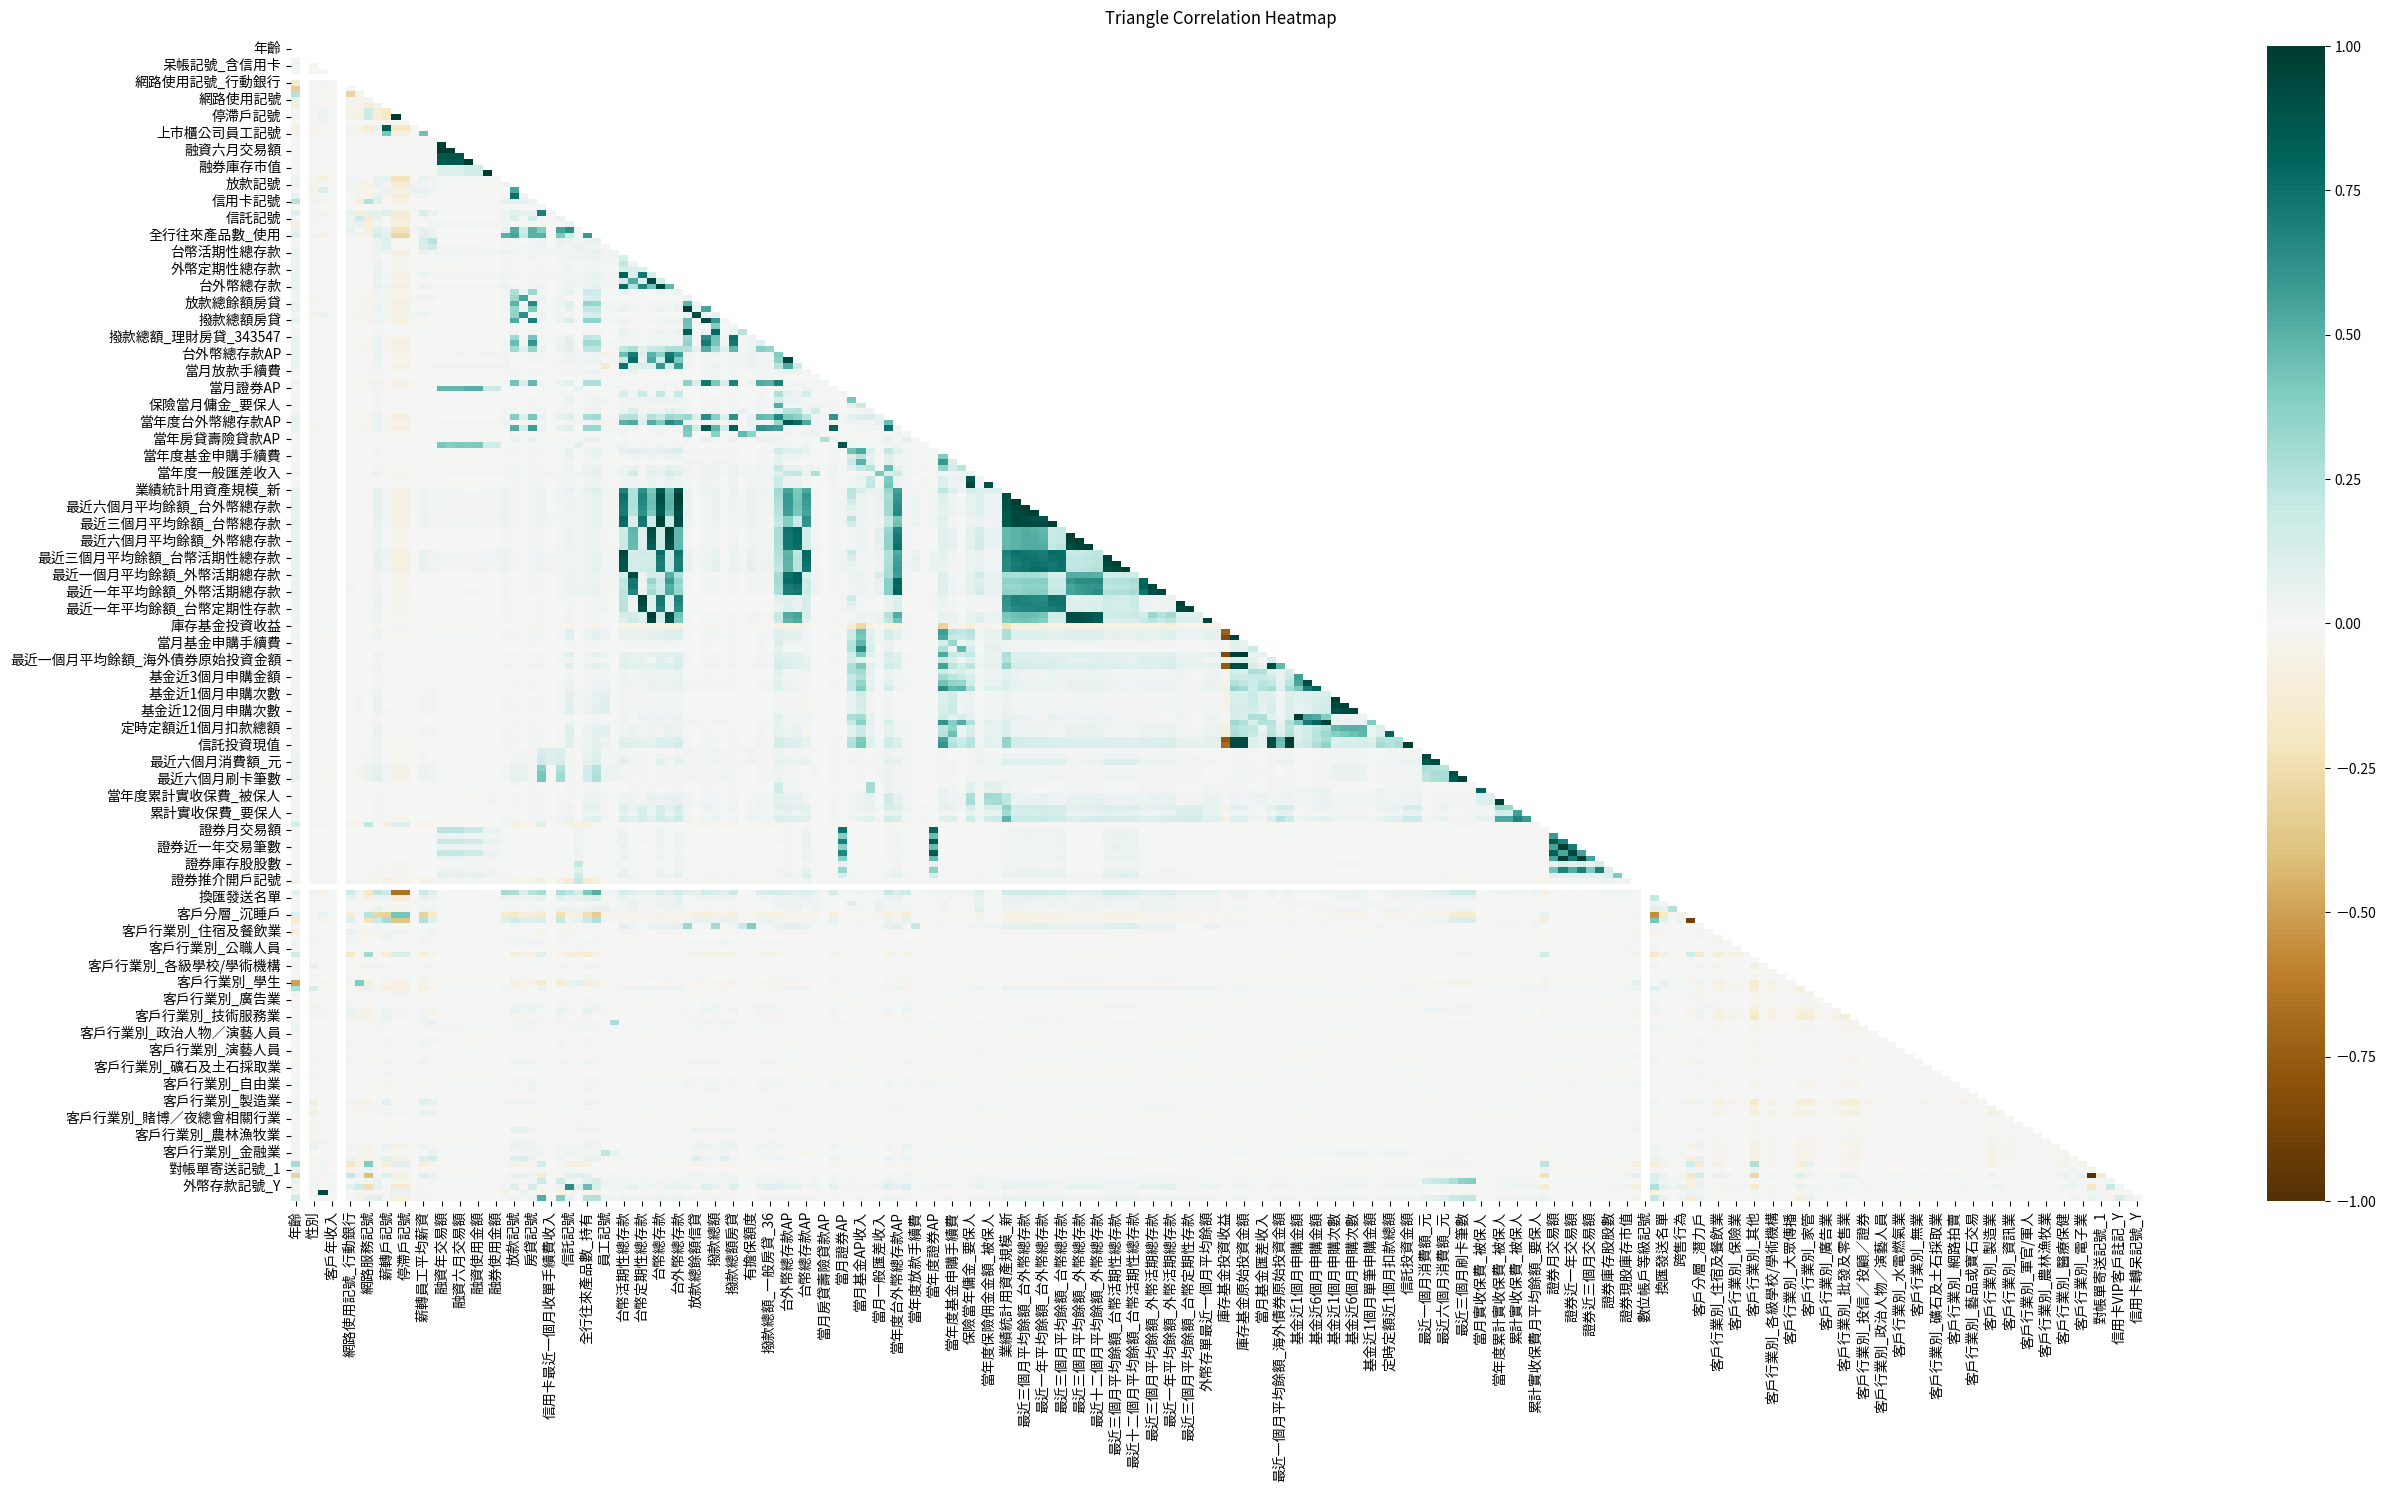

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 15))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(cor, dtype=np.bool))
heatmap = sns.heatmap(cor, mask=mask, vmin=-1, vmax=1, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':12}, pad=16);
plt.show()

# Output

In [ ]:
#Output 前處理後的資料
#壓縮資料
df.to_csv('/content/drive/MyDrive/Sinopac/Rawdata/data202311.csv.zip', compression = 'zip')
#[1066146 rows x 205 columns]

In [4]:
import zipfile

# Specify the path to the zip file
#zip_file_path = 'data202305.csv.zip'
zip_file_path = '/content/drive/MyDrive/Sinopac/Rawdata/data202311.csv.zip'


# Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("Unzipped successfully.")

Unzipped successfully.


In [6]:
df = pd.read_csv('/content/data202311.csv', index_col = 0)
df

,UNINO,年齡,公司戶記號,性別,呆帳記號_含信用卡,客戶年收入,網路會員記號,網路使用記號_行動銀行,小mma記號,網路服務記號,...,客戶行業別_醫療保健,客戶行業別_金融業,客戶行業別_電子業,對帳單寄送記號_0,對帳單寄送記號_1,對帳單寄送記號_2,信用卡VIP客戶註記_Y,外幣存款記號_Y,信用卡轉呆記號_Y,信用卡自動扣款記號_Y
0,19039293TA8,59,0,1.0,0,0.0,1,0,0,3,...,0,0,0,1,0,0,0,0,0,0
1,19042120PA8,54,0,1.0,0,0.0,1,0,0,3,...,0,0,0,0,0,1,0,0,0,0
2,19052324OK8,60,0,1.0,0,0.0,1,0,0,3,...,0,0,0,1,0,0,0,0,0,0
3,19052578MU0,60,0,1.0,0,1000.0,1,0,0,3,...,0,0,0,0,0,1,0,1,0,0
4,19079774PA8,60,0,1.0,0,0.0,1,0,0,3,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066141,Z2229999030,80,0,2.0,0,0.0,1,2,0,3,...,0,0,0,1,0,0,0,0,0,0
1066142,Z2422221010,47,0,2.0,0,1440.0,1,3,0,1,...,0,0,0,0,0,1,0,1,0,0
1066143,Z2422273090,57,0,2.0,0,0.0,1,2,0,1,...,0,0,0,1,0,0,0,0,0,1
1066144,Z2794749990,55,0,2.0,0,0.0,1,0,0,3,...,0,0,0,1,0,0,0,0,0,0


In [8]:
df.pivot_table(index=['換匯發送名單'], columns= '跨售行為', values= 'TOTALNTAMOUNT', margins=True, aggfunc=['mean', 'max', 'min', 'count'])

mean                             max                          min  \
跨售行為    0.0           1.0          All  0.0         1.0         All  0.0   
換匯發送名單                                                                     
0.0     0.0  86653.564700   341.568461  0.0  17474509.0  17474509.0  0.0   
1.0     0.0  82144.932984  1835.136404  0.0   3022469.0   3022469.0  0.0   
All     0.0  85790.517338   401.454295  0.0  17474509.0  17474509.0  0.0   

                      count                 
跨售行為      1.0  All      0.0   1.0      All  
換匯發送名單                                      
0.0     100.0  0.0  1019364  4034  1023398  
1.0     102.0  0.0    41793   955    42748  
All     100.0  0.0  1061157  4989  1066146